In [1]:
import pm4py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
log = pm4py.read_xes('../data/BPI Challenge 2017.xes/BPI Challenge 2017.xes', return_legacy_log_object=True)

c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:39<00:00, 795.48it/s] 


In [3]:
# retain only cases with a final decision by the bank

allowed_events = ["A_Pending", "A_Cancelled", "A_Denied"]

filtered_log = pm4py.filter_event_attribute_values(
    log,
    attribute_key="concept:name",
    values=allowed_events,
    level="case",
    retain=True
)

print(f"Removed: {len(log) - len(filtered_log)} traces")

Removed: 98 traces


### What decisions does the bank make? What correlates with a loan being accepted, denied or refused?

1. Analyze mutally exclusive events across traces
2. dataframe with features per trace and information on the final loan decision

In [4]:
import itertools

# collect activities per trace
trace_activities = []

for trace in log:
    acts = {event["concept:name"] for event in trace}
    trace_activities.append(acts)

# all event types
all_events = sorted({act for acts in trace_activities for act in acts})

# exclusivity matrix (event X does NOT co-occur with event Y)
exclusive_pairs = []

for e1, e2 in itertools.combinations(all_events, 2):
    co_occur = any((e1 in t and e2 in t) for t in trace_activities)
    if not co_occur:
        exclusive_pairs.append((e1, e2))

exclusive_pairs[:20]

[('A_Cancelled', 'A_Denied'),
 ('A_Cancelled', 'A_Pending'),
 ('A_Cancelled', 'O_Accepted'),
 ('A_Cancelled', 'O_Refused'),
 ('A_Cancelled', 'W_Personal Loan collection'),
 ('A_Denied', 'A_Pending'),
 ('A_Denied', 'O_Accepted'),
 ('A_Pending', 'O_Refused'),
 ('O_Accepted', 'O_Refused'),
 ('O_Cancelled', 'W_Personal Loan collection'),
 ('O_Sent (online only)', 'W_Personal Loan collection'),
 ('W_Assess potential fraud', 'W_Shortened completion '),
 ('W_Personal Loan collection', 'W_Shortened completion ')]

In [23]:
durations_h = []
case_lengths = []
max_gaps_h = []
gap_variances_h = []
final_decisions = []
all_case_attributes = []
o_sent_counts = []

decision_events = ["A_Pending", "A_Cancelled", "A_Denied"]

for trace in log:
    all_case_attributes.append(trace.attributes.copy())

    acts = {event["concept:name"] for event in trace}

    # 1) Detect final decision
    decision_label = None
    for d in decision_events:
        if d in acts:
            decision_label = d
            break
    final_decisions.append(decision_label)

    # 2) Case length
    case_lengths.append(len(trace))

    # 3) Extract timestamps
    timestamps = sorted([event["time:timestamp"] for event in trace])

    # Case duration in hours
    start = timestamps[0]
    end   = timestamps[-1]
    duration_h = (end - start).total_seconds() / 3600
    durations_h.append(duration_h)

    # 4) Gaps
    if len(timestamps) > 1:
        gaps_h = [
            (timestamps[i+1] - timestamps[i]).total_seconds() / 3600
            for i in range(len(timestamps) - 1)
        ]
        max_gaps_h.append(max(gaps_h))
        gap_variances_h.append(np.var(gaps_h))
    else:
        max_gaps_h.append(0)
        gap_variances_h.append(0)

    # 5) count the occurence of offers cancelled by the client
    n_sent = sum(1 for event in trace if event["concept:name"] in ["O_Sent (mail and online)", "O_Sent (online only)"])
    o_sent_counts.append(n_sent)

loan_accepted = [1 if x == "A_Pending" else 0 for x in final_decisions]

# Build base df
df = pd.DataFrame({
    "case_length": case_lengths,
    "case_duration_hours": durations_h,
    "max_gap_hours": max_gaps_h,
    "gap_variance_hours": gap_variances_h,
    "final_decision": final_decisions,
    "loan_accepted": loan_accepted,
    "num_o_sent": o_sent_counts
})

# Convert attributes dicts to a dataframe
attr_df = pd.DataFrame(all_case_attributes)

df = pd.concat([df, attr_df], axis=1)

df.head()


,case_length,case_duration_hours,max_gap_hours,gap_variance_hours,final_decision,loan_accepted,num_o_sent,LoanGoal,ApplicationType,concept:name,RequestedAmount
0,40,317.965589,171.729629,942.279061,A_Pending,1,1,Existing loan takeover,New credit,Application_652823628,20000.0
1,31,147.227285,93.910920,310.355131,A_Denied,0,1,Home improvement,New credit,Application_1691306052,10000.0
2,45,307.676747,167.542238,807.797275,A_Pending,1,2,Home improvement,New credit,Application_428409768,15000.0
3,84,647.732610,383.086382,1848.043410,A_Pending,1,2,Car,New credit,Application_1746793196,5000.0
4,21,762.004580,645.610663,19852.600244,A_Cancelled,0,1,Home improvement,New credit,Application_828200680,35000.0


In [6]:
df.ApplicationType.value_counts(normalize=True)


ApplicationType
New credit     0.892443
Limit raise    0.107557
Name: proportion, dtype: float64

In [7]:
df.LoanGoal.value_counts(normalize=True)

LoanGoal
Car                       0.296042
Home improvement          0.243391
Existing loan takeover    0.177759
Other, see explanation    0.094735
Unknown                   0.075058
Not speficied             0.033800
Remaining debt home       0.026723
Extra spending limit      0.019836
Caravan / Camper          0.011711
Motorcycle                0.008728
Boat                      0.006379
Tax payments              0.004824
Business goal             0.000952
Debt restructuring        0.000063
Name: proportion, dtype: float64

In [8]:
df["final_decision"].value_counts()

final_decision
A_Pending      17228
A_Cancelled    10431
A_Denied        3752
Name: count, dtype: int64

#### How are the final decisions distributed in the data?

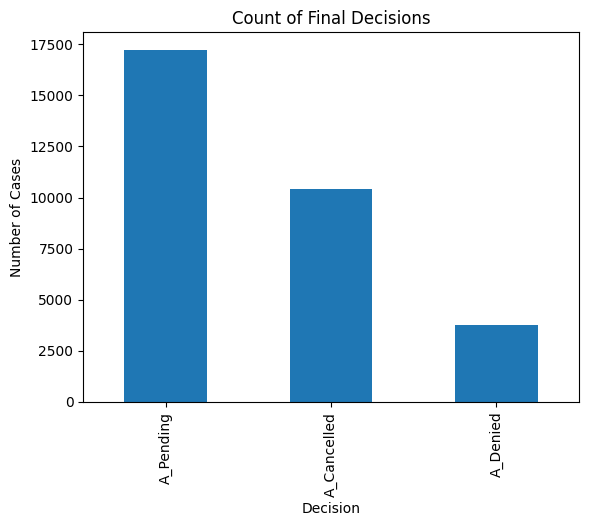

In [9]:
df["final_decision"].value_counts().plot(kind="bar")
plt.title("Count of Final Decisions")
plt.xlabel("Decision")
plt.ylabel("Number of Cases")
plt.show()


#### Do the maximum waiting times (between events of trace) differ by final decision

It seems that both case duration and max waiting time are longer for cancelled applications

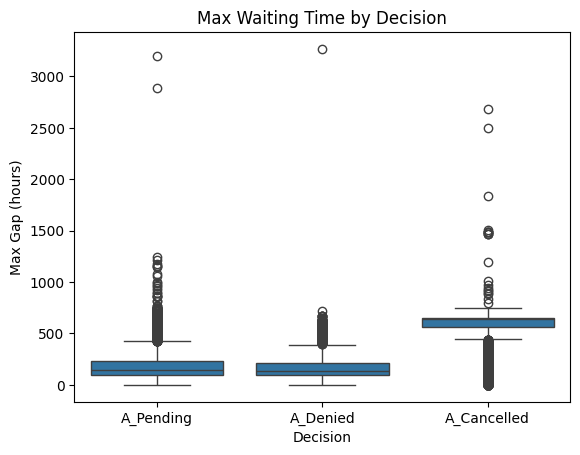

In [10]:
sns.boxplot(data=df, x="final_decision", y="max_gap_hours")
plt.title("Max Waiting Time by Decision")
plt.xlabel("Decision")
plt.ylabel("Max Gap (hours)")
plt.show()


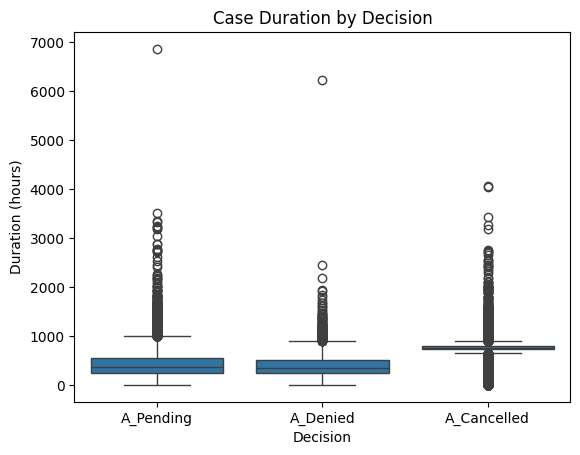

In [11]:
sns.boxplot(data=df, x="final_decision", y="case_duration_hours")
plt.title("Case Duration by Decision")
plt.xlabel("Decision")
plt.ylabel("Duration (hours)")
plt.show()


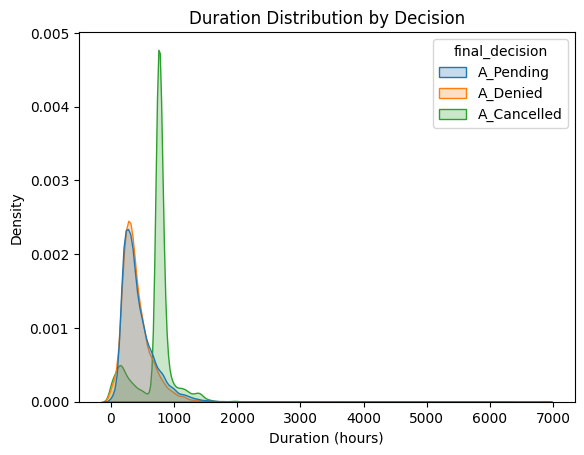

In [12]:
sns.kdeplot(
    data=df,
    x="case_duration_hours",
    hue="final_decision",
    fill=True,
    common_norm=False
)
plt.title("Duration Distribution by Decision")
plt.xlabel("Duration (hours)")
plt.show()


#### How descriptive are the features? Are they strongly correlated with each other

The max time gap and the variance of time gaps are very strongly correlated 0.9. Thus, only one should be included in the regression to avoid issues with collienarity and to retain the interpretability of the predictors

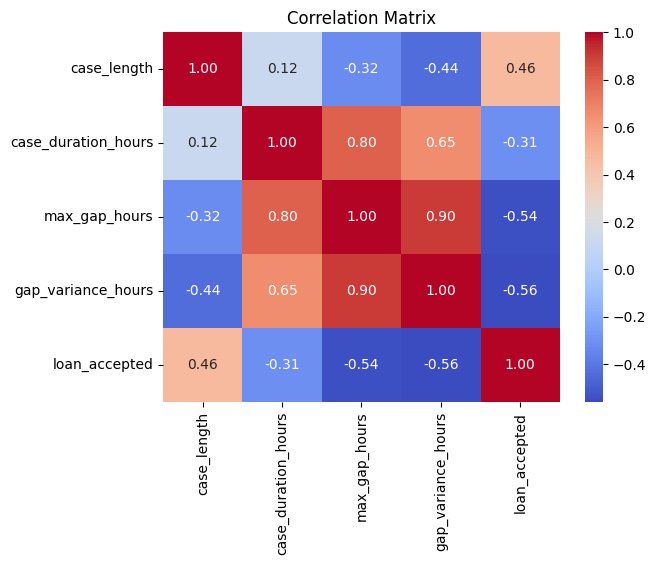

In [13]:
numeric_cols = ["case_length", "case_duration_hours", "max_gap_hours", "gap_variance_hours", "loan_accepted"]
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


### Regression model to predict successful loans

1. Log scale skewed numeric variables
2. Standardize numeric variables
3. Crete dummy variables for categorical features

In [14]:
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

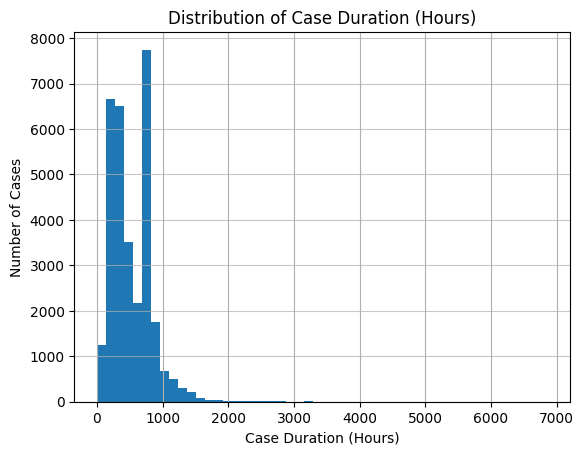

In [15]:
df["case_duration_hours"].hist(bins=50) 

# 2. Update the labels for the duration distribution
plt.title("Distribution of Case Duration (Hours)")
plt.xlabel("Case Duration (Hours)")
plt.ylabel("Number of Cases")
plt.grid(axis='y', alpha=0.7)
plt.show()

In [24]:
df["case_duration_hours"] = np.log1p(df["case_duration_hours"])
df["max_gap_hours"] = np.log1p(df["max_gap_hours"])
df["gap_variance_hours"] = np.log1p(df["gap_variance_hours"])
df["RequestedAmount"] = np.log1p(df["RequestedAmount"])

In [25]:
num_vars = ["case_length", "case_duration_hours", "RequestedAmount", "num_o_sent"]

cat_vars = ["ApplicationType"]

# scale all numeric variables to zero mean and unit std. dev. This increases the comparability across coefficients
scaler = StandardScaler()
df[num_vars] = scaler.fit_transform(df[num_vars])

# Create dummy variables for categorical features
df_dummies = pd.get_dummies(df[cat_vars], drop_first=True)


In [31]:
df_model = pd.concat([df, df_dummies], axis=1)

# Clean column names (replace spaces with underscores)
df_model.columns = [c.replace(' ', '_') for c in df_model.columns]

# Define Formula
formula = """
loan_accepted ~ case_length + case_duration_hours + 
                RequestedAmount + 
                num_o_sent + 
                ApplicationType_New_credit
                
"""

# 4. Fit using smf.logit (lowercase)
result = smf.logit(formula=formula, data=df_model).fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.490456
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          loan_accepted   No. Observations:                31509
Model:                          Logit   Df Residuals:                    31503
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Nov 2025   Pseudo R-squ.:                  0.2879
Time:                        18:13:32   Log-Likelihood:                -15454.
converged:                       True   LL-Null:                       -21702.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              1.4329      0.046    

In [85]:
# print odd ratios for ratio interpretation
odds_ratios = np.exp(result.params)
print(odds_ratios)


Intercept                              4.206958
ApplicationType_New_credit[T.True]     0.306318
case_length                            5.824266
case_duration_hours                    0.500960
RequestedAmount                        0.879536
num_o_sent                             0.831672
RequestedAmount:case_duration_hours    0.896316
dtype: float64


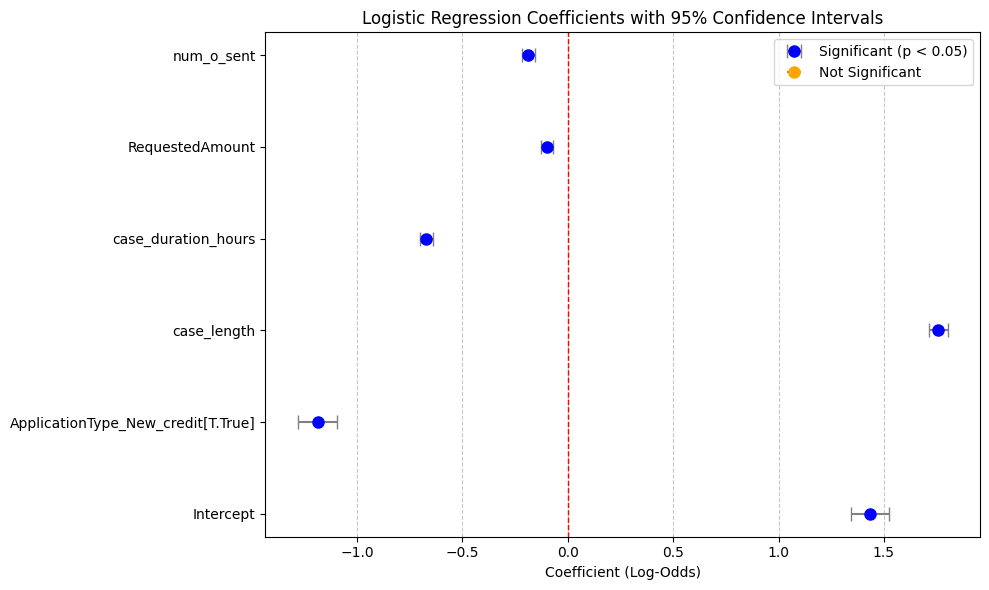

In [36]:
df_plot = pd.DataFrame({
    'Coef': result.params,
    'P_value': result.pvalues,
    'Lower_CI': result.conf_int()[0],
    'Upper_CI': result.conf_int()[1]
})

# 2. Calculate error bar lengths (distance from Coef to CI bounds)
df_plot['error_lower'] = df_plot['Coef'] - df_plot['Lower_CI']
df_plot['error_upper'] = df_plot['Upper_CI'] - df_plot['Coef']

# 3. Setup the plot
plt.figure(figsize=(10, 6))

# 4. Define colors based on significance (p < 0.05)
sig_mask = df_plot['P_value'] < 0.05
non_sig_mask = ~sig_mask

# Plot Significant points (Blue)
plt.errorbar(df_plot.loc[sig_mask, 'Coef'], 
             df_plot.loc[sig_mask].index, 
             xerr=[df_plot.loc[sig_mask, 'error_lower'], df_plot.loc[sig_mask, 'error_upper']], 
             fmt='o', color='blue', ecolor='gray', capsize=5, markersize=8, label='Significant (p < 0.05)')

# Plot Non-Significant points (Orange)
plt.errorbar(df_plot.loc[non_sig_mask, 'Coef'], 
             df_plot.loc[non_sig_mask].index, 
             xerr=[df_plot.loc[non_sig_mask, 'error_lower'], df_plot.loc[non_sig_mask, 'error_upper']], 
             fmt='o', color='orange', ecolor='gray', capsize=5, markersize=8, label='Not Significant')

# plot
plt.axvline(x=0, color='red', linestyle='--', linewidth=1) # Zero line
plt.xlabel('Coefficient (Log-Odds)')
plt.title('Logistic Regression Coefficients with 95% Confidence Intervals')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Resource analysis

Does the processing load and time vary per processing resource? 

I believe both load and time will vary per resource due to maybe part-time emplyoees holidays. This could have implication on assesing the maximum capacity of the process and efficiency of resources

In [192]:
# Convert log to dataframe for easier aggregation
df_log = pm4py.convert_to_dataframe(log)

In [193]:
df_log.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


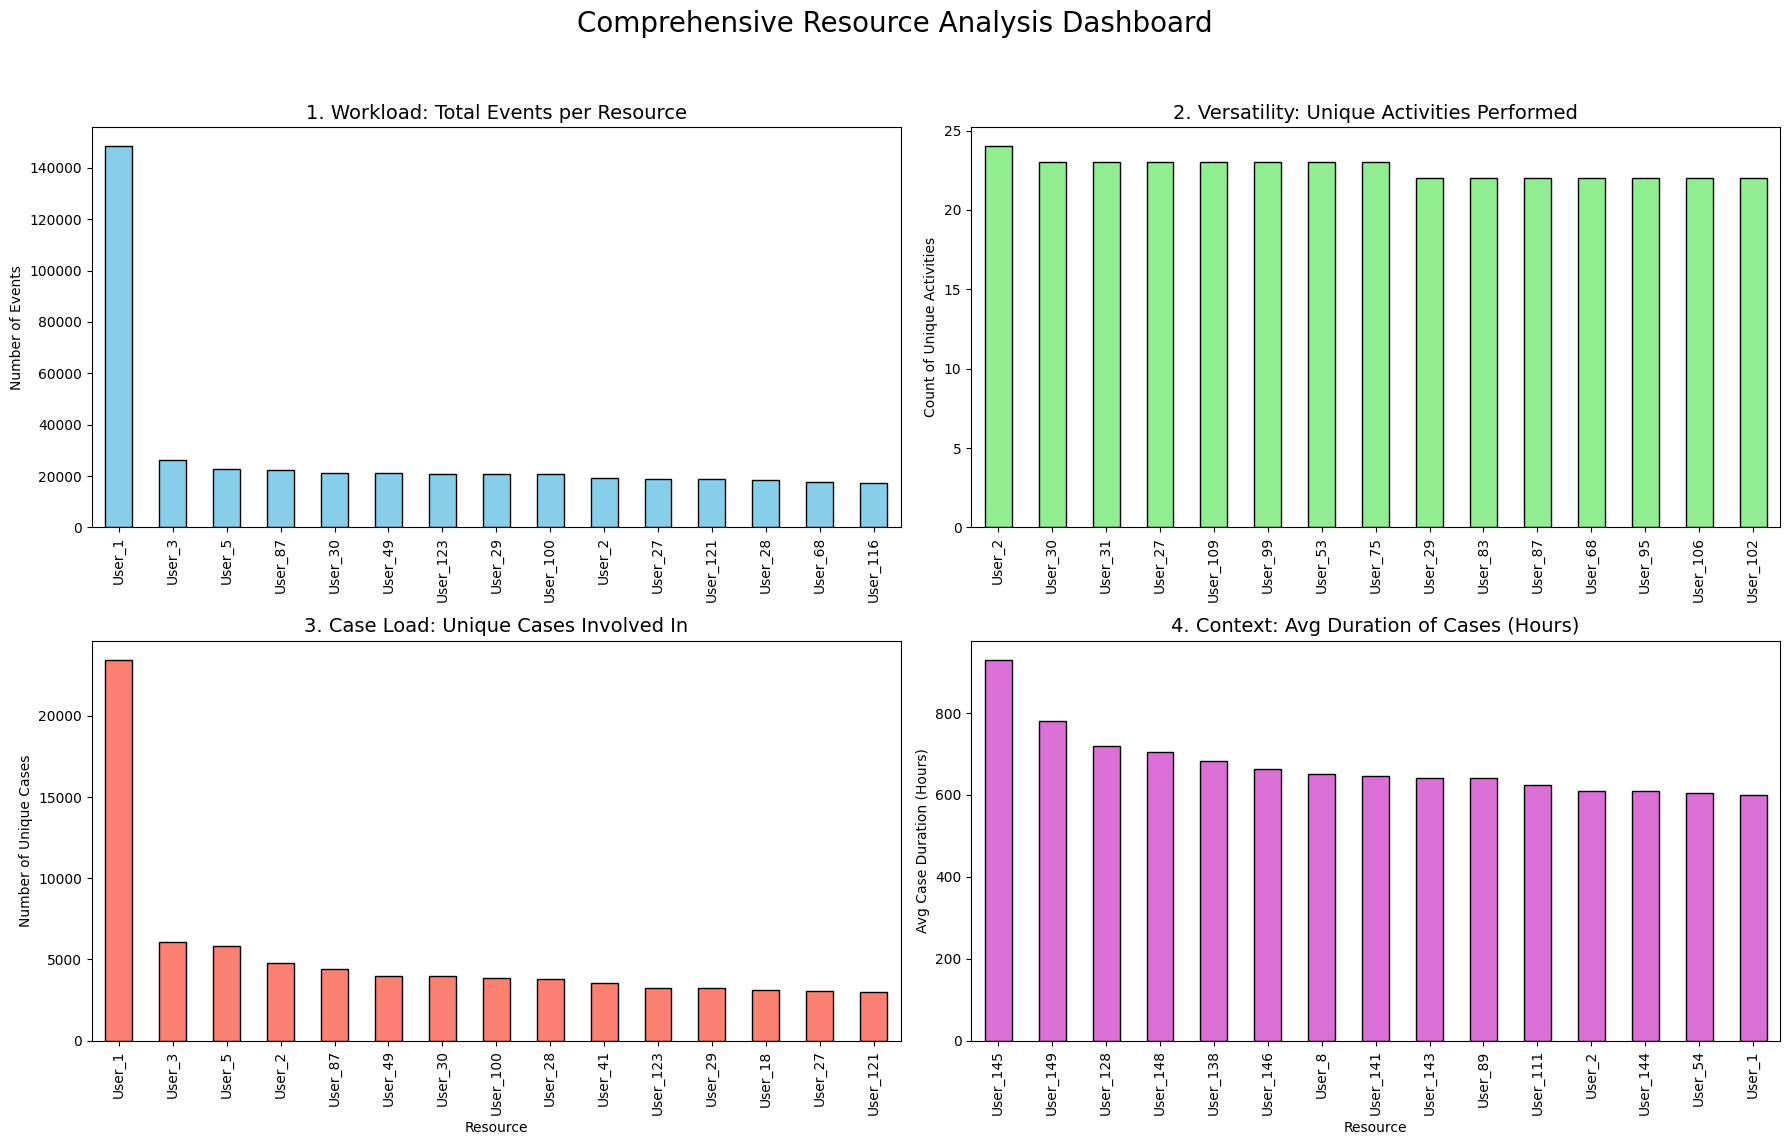

In [ ]:


# 1. Workload: Total Events per Resource
resource_counts = df_log['org:resource'].value_counts().head(15)

# 2. Versatility: Unique Activities
resource_versatility = df_log.groupby('org:resource')['concept:name'].nunique().sort_values(ascending=False).head(15)

# 3. Case Load: Unique Cases Involved In
resource_caseload = df_log.groupby('org:resource')['case:concept:name'].nunique().sort_values(ascending=False).head(15)

# 4. Context: Average Case Duration
case_durations = df_log.groupby('case:concept:name')['time:timestamp'].agg(
    lambda x: (x.max() - x.min()).total_seconds() / 3600
)
df_log['case_duration_h'] = df_log['case:concept:name'].map(case_durations)

# Average the duration of cases where each resource was present
resource_perf = df_log.groupby('org:resource')['case_duration_h'].mean().sort_values(ascending=False).head(15)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3) # Add breathing room

# Chart 1: Activity Volume
resource_counts.plot(kind='bar', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('1. Workload: Total Events per Resource', fontsize=14)
axes[0, 0].set_ylabel('Number of Events')
axes[0, 0].set_xlabel('')

# Chart 2: Versatility
resource_versatility.plot(kind='bar', ax=axes[0, 1], color='lightgreen', edgecolor='black')
axes[0, 1].set_title('2. Versatility: Unique Activities Performed', fontsize=14)
axes[0, 1].set_ylabel('Count of Unique Activities')
axes[0, 1].set_xlabel('')

# Chart 3: Case Load
resource_caseload.plot(kind='bar', ax=axes[1, 0], color='salmon', edgecolor='black')
axes[1, 0].set_title('3. Case Load: Unique Cases Involved In', fontsize=14)
axes[1, 0].set_ylabel('Number of Unique Cases')
axes[1, 0].set_xlabel('Resource')

# Chart 4: Speed Context
resource_perf.plot(kind='bar', ax=axes[1, 1], color='orchid', edgecolor='black')
axes[1, 1].set_title('4. Context: Avg Duration of Cases (Hours)', fontsize=14)
axes[1, 1].set_ylabel('Avg Case Duration (Hours)')
axes[1, 1].set_xlabel('Resource')

plt.suptitle("Comprehensive Resource Analysis Dashboard", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to fit suptitle
plt.show()

In [184]:
avg_resources = df_log.groupby('case:concept:name')['org:resource'].nunique().mean()
unique_resources = len(df_log['org:resource'].unique())

print(f"Average number of resources per case: {avg_resources:.2f}")
print(f"Count of unique resources: {unique_resources}")


Average number of resources per case: 6.98
Count of unique resources: 149


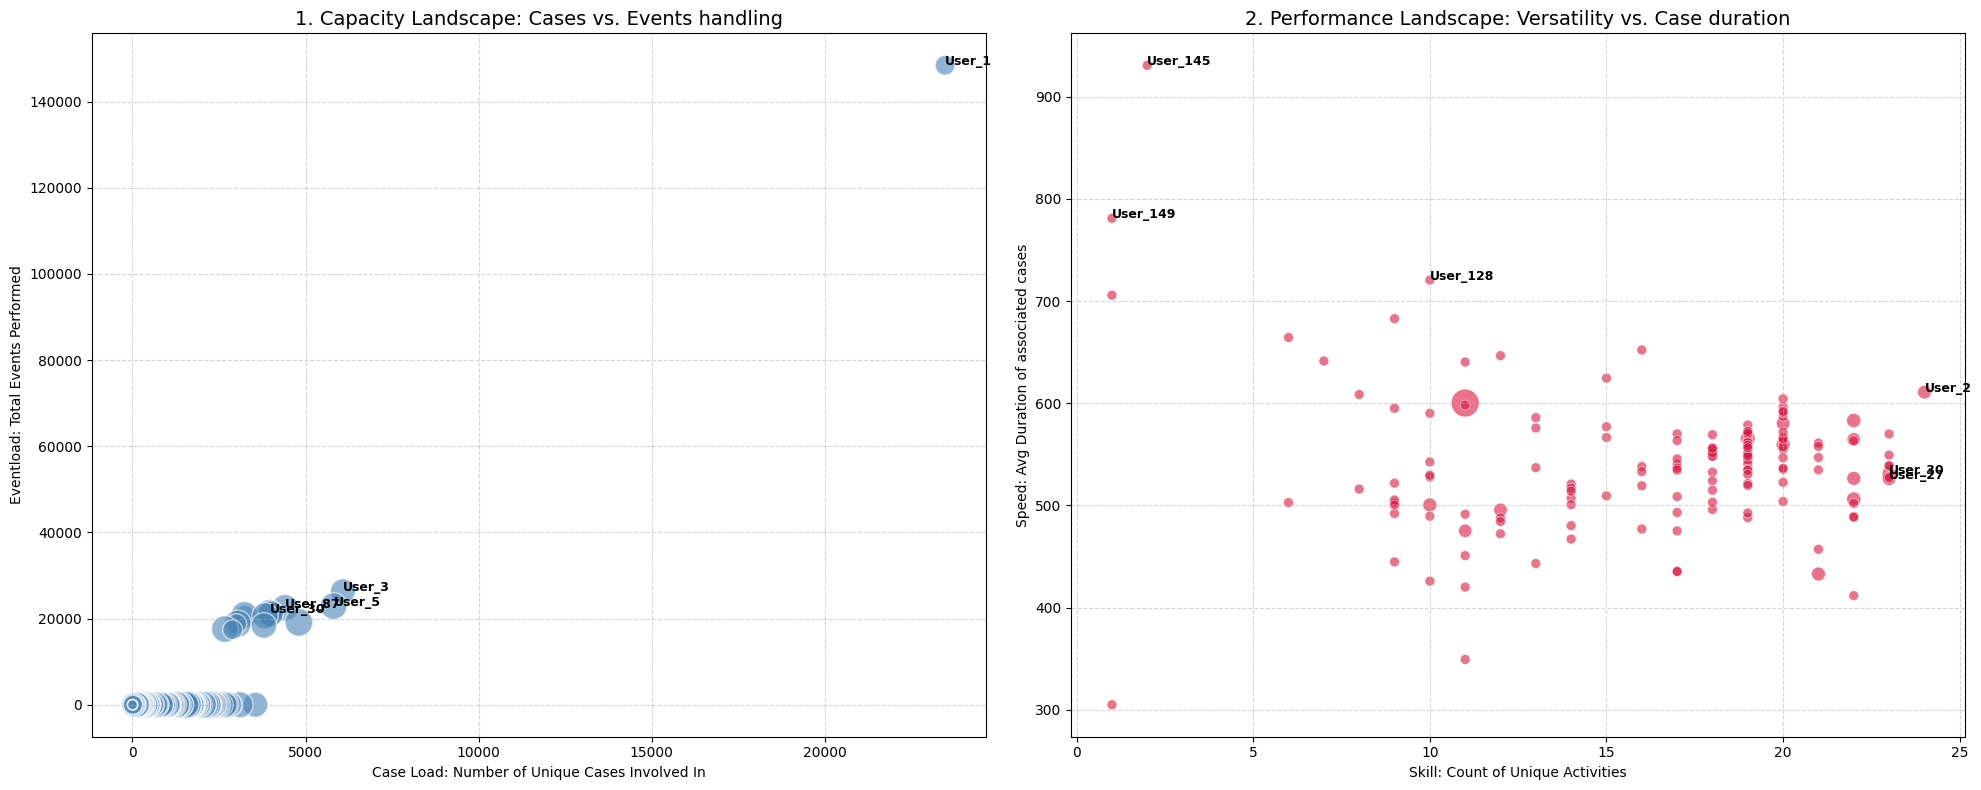

In [ ]:


df_resources = pd.concat([
    resource_counts,       # 1. Total Events
    resource_caseload,     # 2. Unique Cases
    resource_versatility,  # 3. Unique Activities
    resource_perf          # 4. Speed
], axis=1)

# Rename for cleaner coding
df_resources.columns = ['Total_Events', 'Unique_Cases', 'Versatility', 'Speed_Metric']
df_resources = df_resources.fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# CHART 1: VOLUME 
sns.scatterplot(
    data=df_resources, 
    x='Unique_Cases', 
    y='Total_Events', 
    size='Versatility',
    sizes=(50, 400),
    alpha=0.6, 
    ax=axes[0],
    color='steelblue',
    legend=False
)
axes[0].set_title('1. Capacity Landscape: Cases vs. Events handling', fontsize=14)
axes[0].set_xlabel('Case Load: Number of Unique Cases Involved In')
axes[0].set_ylabel('Eventload: Total Events Performed')
axes[0].grid(True, linestyle='--', alpha=0.5)

# Annotate Outliers for Chart 1 (Top 5 by Events)
for i in df_resources.nlargest(5, 'Total_Events').index:
    axes[0].text(df_resources.loc[i, 'Unique_Cases'], df_resources.loc[i, 'Total_Events'], 
                 i, fontsize=9, fontweight='bold', color='black')


# CHART 2: SKILL LANDSCAPE (Versatility vs. Speed)
sns.scatterplot(
    data=df_resources, 
    x='Versatility', 
    y='Speed_Metric', 
    size='Total_Events',
    sizes=(50, 400),
    alpha=0.6, 
    ax=axes[1],
    color='crimson',
    legend=False
)
axes[1].set_title('2. Performance Landscape: Versatility vs. Case duration', fontsize=14)
axes[1].set_xlabel('Versatility: Count of Unique Events handled')
axes[1].set_ylabel('Speed: Avg Duration of associated cases (h)')
axes[1].grid(True, linestyle='--', alpha=0.5)

# Annotate Outliers for Chart 2 (Top 5 by Speed or Versatility)
top_versatile = df_resources.nlargest(3, 'Versatility').index
top_slow = df_resources.nlargest(3, 'Speed_Metric').index
to_label = top_versatile.union(top_slow)

for i in to_label:
    axes[1].text(df_resources.loc[i, 'Versatility'], df_resources.loc[i, 'Speed_Metric'], 
                 i, fontsize=9, fontweight='bold', color='black')

plt.tight_layout()
plt.show()